/home/rob/miniconda3/envs/vitl/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/rob/miniconda3/envs/vitl/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


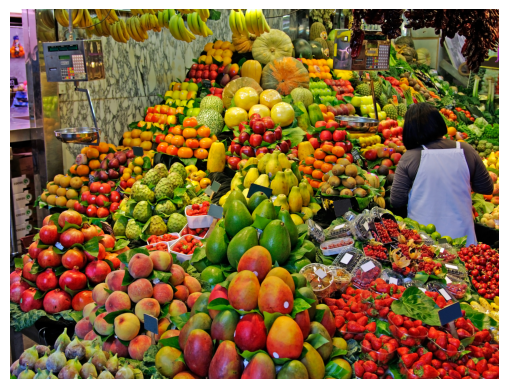

(None, 'input image size (6392, 4832) pixels')

In [1]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as T

# Load a similar sample to the DINOv3 paper
img = Image.open("./assets/market_boqueria2.jpg").convert("RGB")
plt.imshow(img)
plt.axis("off")
plt.show(), f"input image size {img.size} pixels"

In [3]:
def cosine_similarity_map(encoder, img, coords : list[int], patch_size : int = 16):
    w, h = img.size
    patch_h = h // patch_size
    patch_w = w // patch_size

    # Resize to patch size
    w, h = w - w % patch_size, h - h % patch_size
    img = img.resize((w, h))
    
    # Coordinate to patch token location
    coords[0] = coords[0] // patch_size
    coords[1] = coords[1] // patch_size

    to_tensor_fn = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=(0.485,0.456,0.406),
                    std=(0.229,0.224,0.225)),
    ])
    x = to_tensor_fn(img).unsqueeze(0).cuda()

    with torch.no_grad():
        feats = encoder.forward_features(x)["x_norm_patchtokens"][0]
        feats = encoder.head(feats)

    # The patch index 
    idx = coords[1] * patch_w + coords[0]
    similarities = F.cosine_similarity(feats[idx].unsqueeze(0), feats)
    
    return similarities.view(patch_h, patch_w).cpu(), coords

def plot_cosine_similarity(encoder, img, coords: list[tuple[int, int]], patch_size: int = 16):
    n = len(coords)
    fig, axes = plt.subplots(1, n + 1, figsize=(5 * (n + 1), 5))

    # Original image
    axes[0].imshow(img)
    axes[0].set_title("Original image")
    axes[0].axis("off")

    # Heatmaps for each coordinate
    for i, coord in enumerate(coords, start=1):
        sim, (px, py) = cosine_similarity_map(encoder, img, coord, patch_size)
        axes[i].imshow(sim, cmap="viridis")
        axes[i].scatter(px, py, color="red", marker="+", s=100, linewidths=2)
        axes[i].set_title(f"Patch @ {coord}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

### Qualitative Evaluation

Using cache found in /home/rob/.cache/torch/hub/facebookresearch_dinov2_main


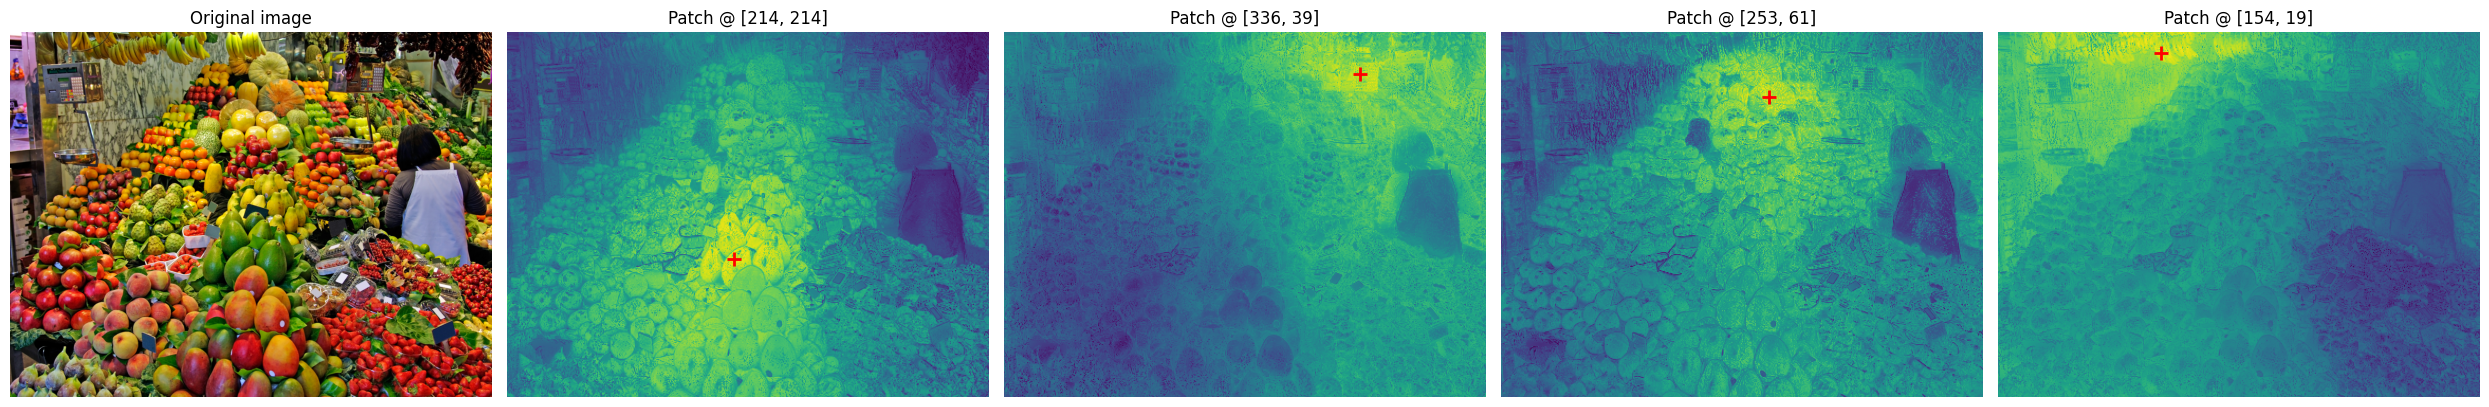

In [45]:
# First evaluation with DINOv2
encoder = torch.hub.load(
    repo_or_dir="facebookresearch/dinov2",
    source="github",
    model="dinov2_vits14_reg"
).cuda().eval()

coords = [[3000, 3000], [4710, 555], [3550, 860], [2164, 274]]
plot_cosine_similarity(encoder, img, coords, patch_size=14)

Using cache found in /home/rob/.cache/torch/hub/facebookresearch_dinov3_main


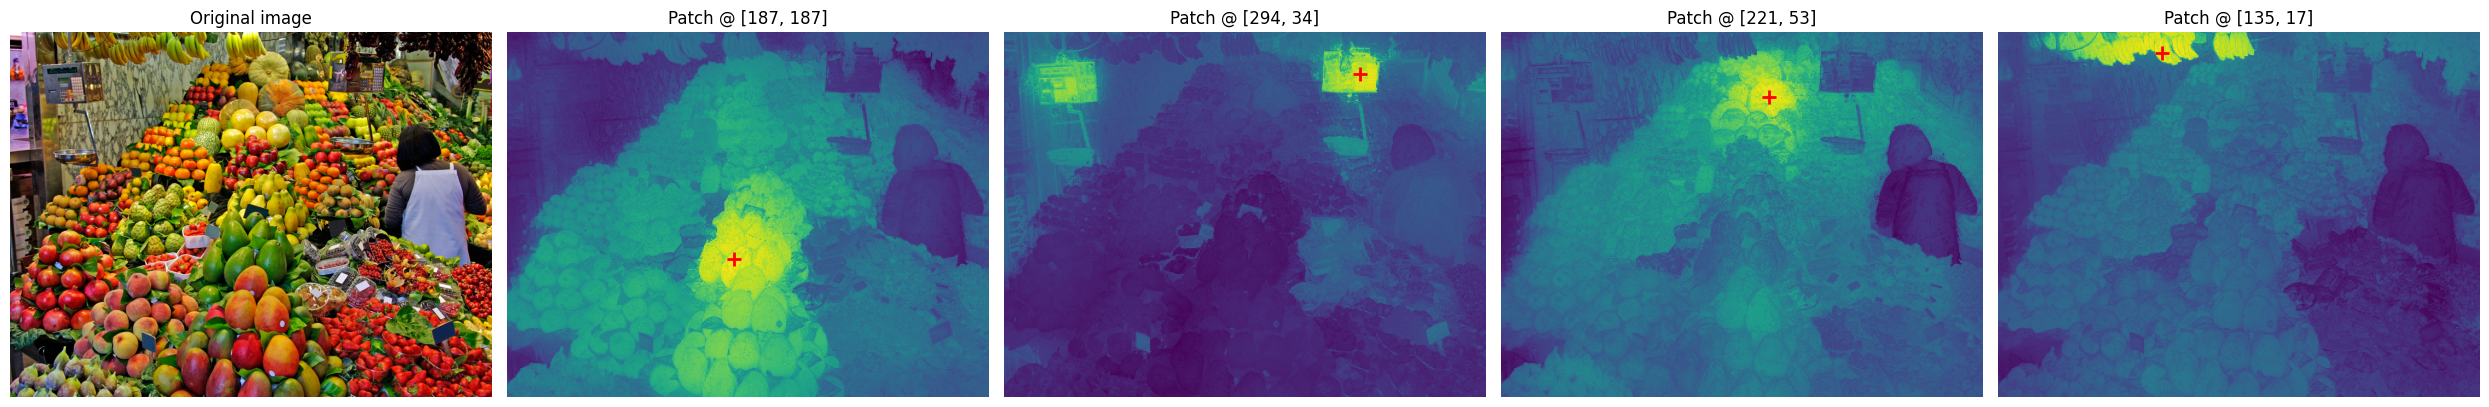

In [51]:
# Examples for DINOv3
encoder = torch.hub.load(
    repo_or_dir="facebookresearch/dinov3",
    weights="weights/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth",
    source="github",
    model="dinov3_vitl16"
).cuda().eval()

coords = [[3000, 3000], [4710, 555], [3550, 860], [2164, 274]]
plot_cosine_similarity(encoder, img, coords, patch_size=16)

### Quantative Evaluation

In [6]:
import yaml
import torch.nn as nn

from rasa import RASA
from rasa.metrics import PredsmIoUKmeans
from rasa.data import get_training_data

encoder = torch.hub.load(
    repo_or_dir="facebookresearch/dinov3",
    weights="weights/dinov3_vits16_pretrain_lvd1689m-08c60483.pth",
    source="github",
    model="dinov3_vits16"
).cuda().eval()

Using cache found in /home/rob/.cache/torch/hub/facebookresearch_dinov3_main


In [22]:
# Dataset configuration
with open("./configs/rasa.yml", "r") as f:
    config = yaml.safe_load(f)

datamodule = get_training_data(config["data"], batch_size=16, num_workers=4)
val_loader = datamodule.val_dataloader()

# Overclustering with k=[21, 100, 300] clusters like in Franca
preds_miou_x = PredsmIoUKmeans([21, 100, 300], num_gt_classes=21)

In [23]:
def calculate_overclustering_iou(preds_miou, encoder, datamodule, n_batches=40):
    """
    Processes embeddings and masks, updates preds_miou, computes metrics.
    Returns a dict of results.
    """

    imgs = []
    with torch.no_grad():
        for idx, batch in enumerate(val_loader):
            y = batch["masks"].float().cuda()
            y_valid = y != 255
            imgs.append(batch["images"].cpu())
            
            out_dict = encoder.forward_features(batch["images"].cuda())
            x = out_dict["x_norm_patchtokens"]
            
            res_w = int(np.sqrt(x.size(1)))
            x = x.permute(0, 2, 1).reshape(y.size(0), encoder.embed_dim, res_w, res_w)
            preds_miou.update(y_valid, x, y)
            
            if idx > n_batches:
                break

    res_kmeans = preds_miou.compute(is_global_zero=True)
    imgs = torch.cat(imgs, 0)
    
    return [{"k": k, "miou": res_k[0]} for k, name, res_k in res_kmeans], imgs


result, input_images = calculate_overclustering_iou(preds_miou_x, encoder, datamodule)
result


Objective improved: keep new clusters
Sampling a subset of 5376 / 33718272 for training
Clustering 5376 points in 50D to 21 clusters, redo 5 times, 50 iterations
  Preprocessing in 1.87 s
Outer iteration 0 / 5
  Iteration 49 (0.03 s, search 0.03 s): objective=665244 imbalance=1.127 nsplit=0           
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 49 (0.06 s, search 0.05 s): objective=659055 imbalance=1.090 nsplit=0           
Objective improved: keep new clusters
Outer iteration 2 / 5
  Iteration 49 (0.09 s, search 0.07 s): objective=664013 imbalance=1.127 nsplit=0           
Outer iteration 3 / 5
  Iteration 49 (0.12 s, search 0.10 s): objective=665322 imbalance=1.183 nsplit=0           
Outer iteration 4 / 5
seg map preds have size (31960941,) s): objective=662116 imbalance=1.185 nsplit=0           
Parallelizing iou computation
took 25.21806263923645 seconds
Matched clusters to gt classes:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,

[{'k': 21, 'miou': 0.15674015585084192},
 {'k': 100, 'miou': 0.41434235771563915},
 {'k': 100, 'miou': 0.4656130472382712}]

In [24]:
preds_per_k = preds_miou_x.predict_only(
    is_global_zero=True,
    remap_to_gt=False,
    precision_based=False,
)

len(preds_per_k)

[(21, array([5, 5, 5, ..., 9, 9, 9])), (100, array([40, 40, 40, ..., 76, 76, 76]))]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6225708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6225708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.5877123].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.5877123].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.

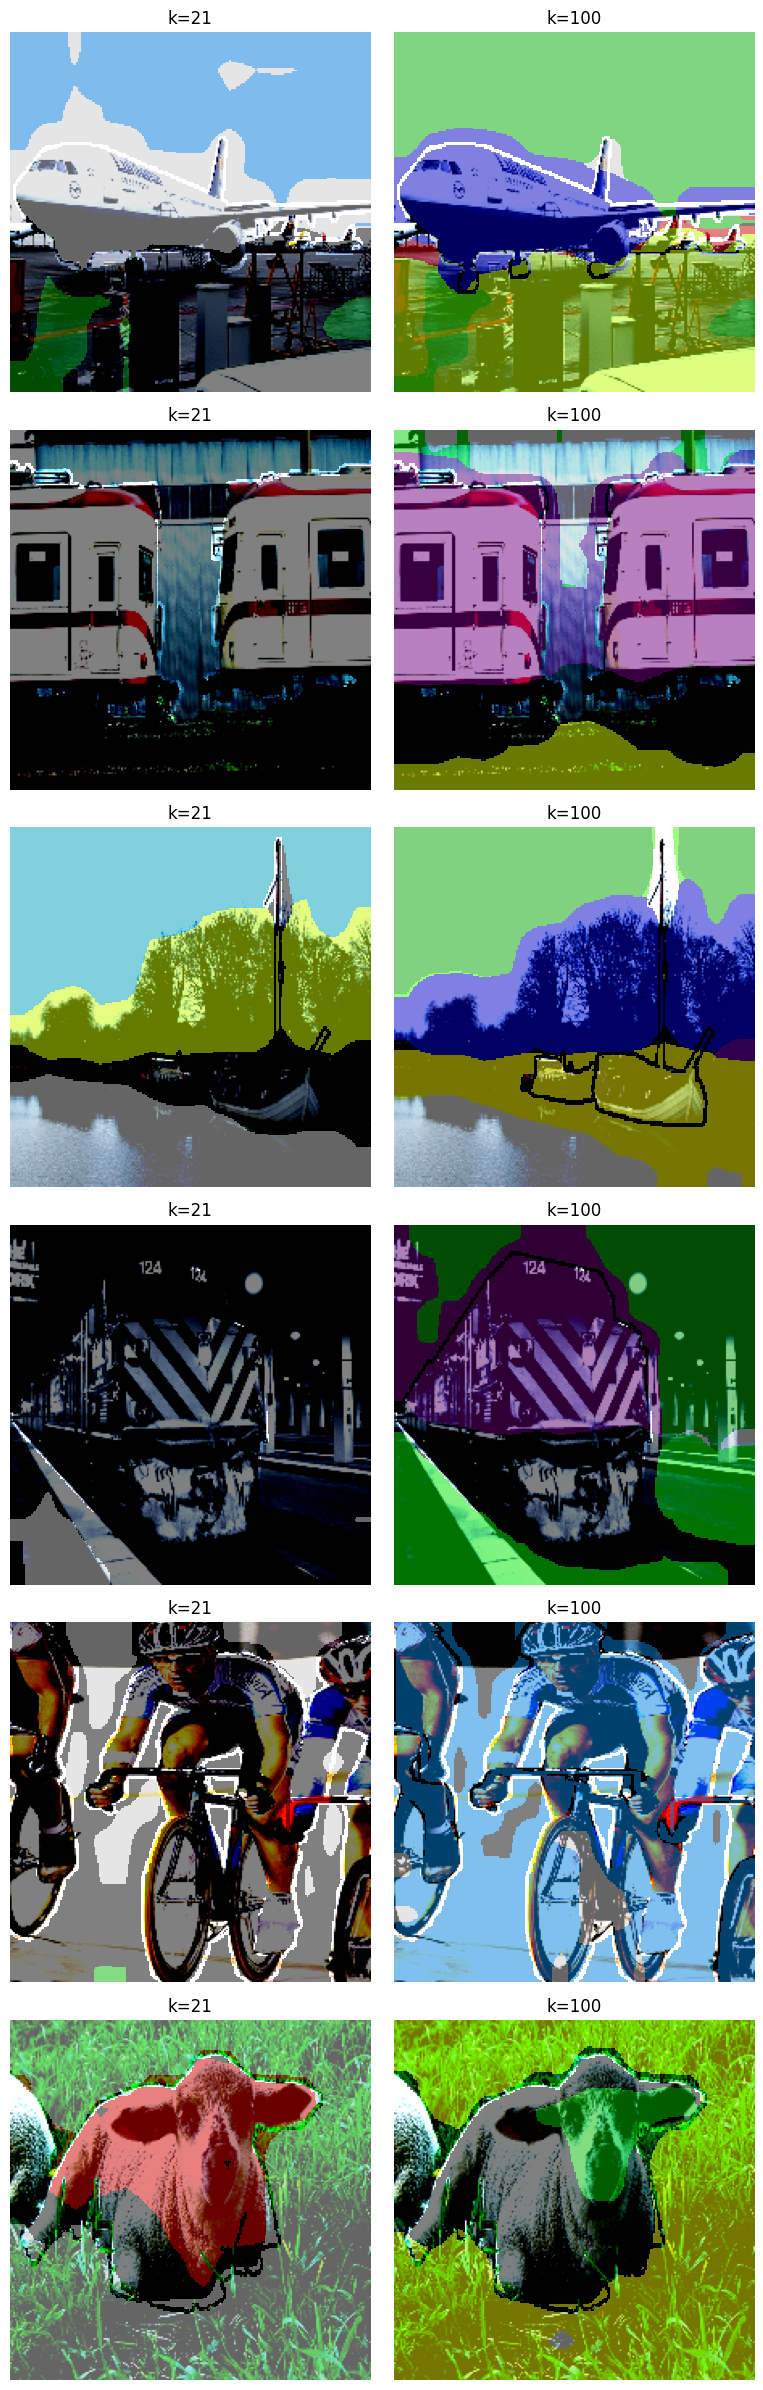

In [38]:
valid_masks = torch.cat(preds_miou_x.masks, dim=0).cpu().numpy().astype(bool)
B, H, W = valid_masks.shape

def flat_to_full(valid_masks, flat_preds, *, fill_value=0):
    """Map 1D preds over all valid pixels (across batch) back to (B,H,W)."""
    full = np.full(valid_masks.shape, fill_value, dtype=np.int64)
    full[valid_masks] = flat_preds
    return full

def draw_overlay(ax, img, pred, valid_masks, title):
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(title)

    if valid_masks is not None:
        pred = np.ma.masked_where(pred == valid_masks, pred)
    ax.imshow(pred, alpha=0.5, cmap="nipy_spectral", interpolation="nearest")

# Rebuild all k variants
pred_full_by_k = {k: flat_to_full(valid_masks, flat) for k, flat in preds_per_k}

N = min(6, B)
n_k = pred_full_by_k.keys()
fig, axs = plt.subplots(N, 2, figsize=(8, 4*N))
axs = np.atleast_2d(axs)
for i in range(N):
    img = imgs[i].permute(1, 2, 0).numpy()
    for idx, k in enumerate(n_k):
        draw_overlay(axs[i, idx], img, pred_full_by_k[k][i], valid_masks[i], f"k={k}")

plt.tight_layout()
plt.show()

In [40]:
preds_miou_x.reset()

In [ ]:
# TODO: Load in the RASA found weights
# TODO: Evaluate the results

In [ ]:

# ckpt_path = "logs/output/last-v7.ckpt"
# model = RASA.load_from_checkpoint(ckpt_path, encoder=encoder)  # your LightningModule
encoder = model.model.encoder

encoder

def build_rasa_matrix(head) -> torch.Tensor:
    """Build effective RASA linear operator L (D×D)."""
    D = head.input_dim
    device = head.pos_pred.weight.device
    L = torch.eye(D, device=device)

    layers = list(head.pre_pos_layers) + [head.pos_pred]
    for ll in layers:
        vr = ll.weight[0] / ll.weight[0].norm()
        vc = ll.weight[1] / ll.weight[1].norm()

        vc = vc - (vr @ vc) * vr
        vc = vc / vc.norm()

        P = torch.outer(vr, vr) + torch.outer(vc, vc)
        Lt = torch.eye(D, device=device) - P
        L = Lt @ L
    return L


def integrate_rasa_into_encoder(encoder: nn.Module, head) -> None:
    """
    Replace encoder.head (nn.Identity) with a Linear layer that 
    folds in the RASA transformation.
    """
    L = build_rasa_matrix(head)  # D×D
    D = L.shape[0]

    # create a new linear head that just applies L
    new_head = nn.Linear(D, D, bias=False).to(L.device)
    with torch.no_grad():
        new_head.weight.copy_(L.T)  # Linear applies x @ W.T

    encoder.head = new_head
    print("Replaced encoder.head with RASA-adjusted Linear layer.")


# --- usage example ---
# Load your LightningModule with encoder + RASAHead
# model = RASA.load_from_checkpoint("path/to/last.ckpt")
encoder = model.model.encoder
rasa_head = model.model.head  # trained RASAHead

# Absorb RASA into encoder.head
integrate_rasa_into_encoder(encoder, rasa_head)

# Now you can drop model.head completely
# model.head = nn.Identity()
